In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import stefcal
import simulation 
import pointSourceGenerator as psg
import numpy.fft as fft
import scipy.signal as signal
from joblib import Parallel, delayed
import multiprocessing
import copy
n_cpu=multiprocessing.cpu_count()
import cosmology
import delayGridding as dG
littleh=0.68
c=3e8
pi=np.pi

0.048252


In [2]:
def xyz2nsew(lat,inverse=False):
    output=np.array([[0.,1.,0.],
                     [-np.sin(lat),0.,np.cos(lat)],
                     [np.cos(lat),0.,np.sin(lat)]])
    if(inverse):
        output=np.linalg.invert(output)
    return output

def invRotLat(positions,lat):
    rMat=xyz2nsew(lat)
    output=np.zeros_like(positions)
    for i in range(positions.shape[0]):
        output[i,:]=np.dot(rMat,positions[i,:])
    return output

In [3]:
latitude=np.radians(52.)
#antLocs=np.loadtxt('MWA_128T_antenna_locations_MNRAS_2012_Beardsley_et_al.txt',skiprows=6)[:,:3]
antLocs=np.loadtxt('LOFAR_HBA_antenna_locations.txt')
#antLocs=np.loadtxt('/Users/aaronew/Dropbox (MIT)/Science/data/array_layouts/LOFAR_HBA_antenna_locations.txt')
#nant=len(antLocs/2)
#antLocs=antLocs[:nant/2,:]
antLocs=invRotLat(antLocs,latitude)[:48,:2]
nAnt=len(antLocs)
band=20e6
df=100e3
cFreq=150e6
dAnt=30.
sAnt=0.45*c/(cFreq*dAnt)
testArray=simulation.DriftArray(antLocs[:,:2],dAnt=dAnt,b=band,df=df,f0=cFreq)
#testArray_noPara=simulation.DriftArray(antLocs[:,:2],dAnt=dAnt,b=band,df=df)
testArrayModel=simulation.DriftArray(antLocs[:,:2],dAnt=dAnt,b=band,df=df,f0=cFreq)

In [4]:
#generate a source catalog from 0.5 Jy min flux
nsrc=120000
'''
srcList=simulation.drawRandomSources(.01)
beamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)
#arrange by column
apparentFlux=srcList[:,2]*beamVals
srcList=srcList[np.argsort(apparentFlux),:][-nsrc:,:][::-1,:]
del apparentFlux
cutoff=0.035
maxFlux=srcList[:,2].max()
srcList=np.vstack([srcList,[0.,0.,maxFlux*3.,-0.5]])
brightSources=srcList[srcList[:,2]>cutoff,:]
print srcList[:,2].min()
print srcList[:,2].max()
'''

'\nsrcList=simulation.drawRandomSources(.01)\nbeamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)\n#arrange by column\napparentFlux=srcList[:,2]*beamVals\nsrcList=srcList[np.argsort(apparentFlux),:][-nsrc:,:][::-1,:]\ndel apparentFlux\ncutoff=0.035\nmaxFlux=srcList[:,2].max()\nsrcList=np.vstack([srcList,[0.,0.,maxFlux*3.,-0.5]])\nbrightSources=srcList[srcList[:,2]>cutoff,:]\nprint srcList[:,2].min()\nprint srcList[:,2].max()\n'

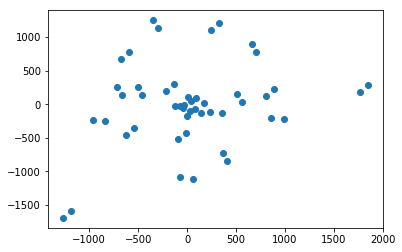

In [5]:
plt.scatter(antLocs[:,0]-np.median(antLocs[:,0]),antLocs[:,1]-np.median(antLocs[:,1]))

In [6]:
#generate a source catalog from 0.5 Jy min flux
nsrc=120000
#srcList=psg.drawRandomSources(.1)
srcList=srcList=np.load('mwa128_wSim_sources.npy')
beamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)
#arrange by column
#apparentFlux=srcList[:,2]*beamVals
#srcList=srcList[np.argsort(apparentFlux),:][-nsrc:,:][::-1,:]
#del apparentFlux
cutoff=1
maxFlux=(srcList[:,2]*beamVals).max()
srcList=np.vstack([srcList,[0.,0.,maxFlux*3.,-0.5]])
brightSources=srcList[srcList[:,2]>cutoff,:]
#print srcList[:,2].min()
#print srcList[:,2].max()

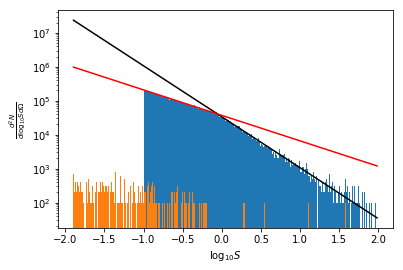

In [7]:
beamVals=simulation.airy_beam(np.linalg.norm(srcList[:,:2],axis=1),150e6,dAnt)

dlogsbin=0.01
binEdges=np.log10(.01)+np.arange(10,400)*dlogsbin
binCenters=binEdges[:-1]+dlogsbin/2
counts,_=np.histogram(np.log10(srcList[:,2]),binEdges)
plt.bar(binCenters,counts/dlogsbin,width=dlogsbin)
ys1=np.log(10.)*2*pi*3200*10**(-1.5*binCenters)*.88**2.5
ys2=np.log(10.)*2*pi*3200*10**(-.75*binCenters)*.88**1.75

counts,_=np.histogram(np.log10(beamVals*srcList[:,2]),binEdges)
plt.bar(binCenters,counts/dlogsbin,width=dlogsbin)

plt.plot(binCenters,ys1,color='k')
plt.plot(binCenters,ys2,color='r')
plt.xlabel('$\\log_{10} S$')
plt.ylabel('$\\frac{d^2N}{d\\log_{10} S d\\Omega}$ ')
plt.yscale('log')


In [8]:
print len(srcList)
print len(brightSources)

108245
9622


In [9]:
testArray.setSourceList(srcList)
testArrayModel.setSourceList(brightSources)
#compute visibilities
testArray._computeVisibilities(parallel=True)
#testArray_noPara._computeVisibilities(parallel=False)
testArrayModel._computeVisibilities(parallel=True)



In [10]:
#vCube=testArray.visCube
#vCubeNP=testArray.visCube
#plt.imshow(np.log10(np.abs(1-vCube/vCubeNP)))/'
#plt.colorbar()

In [11]:
#generate some gains with a ripple that has random phases and amplitudes
refAnt=0
rScale=1e-2
rDelay=1200e-9
rAmp=rScale*np.abs(np.random.randn(len(antLocs)))
rPhase=np.random.rand(len(antLocs))
gains=np.zeros((len(testArray.fAxis),len(antLocs)),dtype=complex)
for gnum in range(gains.shape[1]):
    gains[:,gnum]=1./(1.-rAmp[gnum]*np.exp(2j*np.pi*(rDelay*testArray.fAxis+rPhase[gnum])))
gains[:,refAnt]=np.abs(gains[:,refAnt])    

In [12]:
def getCalibrationGrid(array,arrayModel,gainsTrue,gainsEstimated,flags,nCells=80):
    modelVis=copy.copy(arrayModel.visCube)
    array.applyGains(gainsTrue)
    array.correctGains(gainsEstimated)
    array.visCube-=modelVis
    #kperp,kpara,vGrid=array.getCosmologyDVisGrid()
    vC=array.visCube
    bLens=np.linalg.norm(array.separations,axis=1)
    kperp,kpara,vGrid=dG.delayTransformAndGrid(vC,bLens,array.f0,array.df,nCells,bLens.max()*array.f0/c,array.dAnt,flags)
    array.visCube+=modelVis
    array.correctGains(gainsTrue)
    array.applyGains(gainsEstimated)
    return kperp,kpara,vGrid

In [13]:
sigma_w=150.
weights=np.exp(-np.linalg.norm(testArray.separations,axis=1)**2./(2.*sigma_w**2.))
nvis=0
regFactor=1e-6
weightsMatrix=np.zeros((testArray.nAnt,testArray.nAnt),dtype=complex)
for i in range(testArray.nAnt):
    for j in range(i):
        weightsMatrix[i,j]=weights[nvis]
        weightsMatrix[j,i]=weights[nvis]
        nvis+=1
weightsMatrix[weightsMatrix<regFactor]=regFactor

In [14]:
def computeNeff(wMat):
    nEff=np.zeros(wMat.shape[0])
    for nA in range(wMat.shape[0]):
        nEff[nA]=np.abs(wMat[nA,:]).sum()/np.abs(wMat[nA,:]).max()
    return nEff

def trimNeff(wMat,threshold=2):
    wMat_c=copy.deepcopy(wMat)
    vFlags=np.empty(wMat_c.shape,dtype=bool);vFlags[:]=False
    vFlagsL=np.empty(len(wMat_c)*(len(wMat_c)-1)/2,dtype=bool);vFlagsL[:]=False
    nEff=computeNeff(wMat_c)
    nFlag=0
    nvis=0
    while(np.any(nEff<threshold)):
        for i in range(wMat_c.shape[0]):
            if(nEff[i]<threshold):
                maxInd=np.where(wMat_c[i,:]==wMat_c[i,:].max())[0][0]
                wMat_c[i,maxInd]=0.
                wMat_c[maxInd,i]=0.
                vFlags[maxInd,i]=True
                vFlags[i,maxInd]=True
                nFlag+=1        
        nEff=computeNeff(wMat_c)
    for i in range(len(vFlags)):
        for j in range(i):
            vFlagsL[nvis]=vFlags[i,j]
            nvis+=1
    antFlag=np.empty(wMat.shape[0],dtype=bool)
    antFlag[:]=False
    for i in range(wMat.shape[0]):
        antFlag[i]=np.all(wMat_c[i,:]==0)
    return nFlag,antFlag,wMat_c,vFlags,vFlagsL
                
            

In [15]:
print computeNeff(weightsMatrix)


[ 1.98073789  8.1470924   7.02996166  6.15693057  6.85349615  7.11873178
  6.74618958  5.57298522  2.36983771  1.5523124   2.40221684  1.02345994
  1.66297865  1.01692958  1.04572966  1.84798279  1.2196844   1.00330199
  1.00006794  1.21052805  1.02739224  1.00006794  1.42036363  1.00325341
  1.17800306  8.30645256  8.48589524  7.50291872  8.6176171   8.5799483
  8.04102268  3.08015482  3.45446455  1.88940684  2.43335521  1.02179817
  1.14562001  1.01611792  1.02323418  2.17126977  1.25861999  1.02843308
  1.00006794  1.06650577  1.00493185  1.00006794  1.07134793  1.01727231]


In [16]:
nFlag,aFlag,wMat_t,flagMat,flagList=trimNeff(weightsMatrix)
print aFlag
print nFlag
print computeNeff(wMat_t)
#reassign antennas 

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
90
[  2.49723471   8.1470924    7.02996166   6.15693057   6.77924216
   7.11873178   6.74618958   5.57282525   2.30049372   2.44264048
   2.87988484   2.1431498    2.3156784    2.1865921    3.24336557
   2.22686859   2.65537489   2.20371447  47.           6.3411809
   2.70028952  47.           9.20215089   2.20502358   4.5281442
   8.30645256   8.48589524   7.50291872   8.6176171    8.5799483
   8.04102268   2.76638584   2.85354746   2.20054258   2.23098645
   2.58508058   4.90567399  42.           3.63147754   2.80879831
   2.5980258    4.87085756  46.          17.77651135  43.          46.          41.
  42.        ]


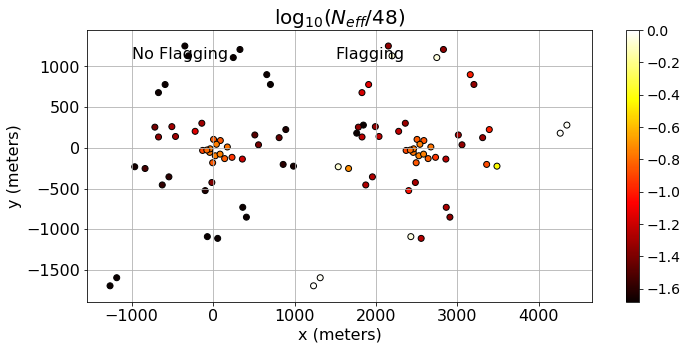

In [17]:
plt.scatter(antLocs[:,0]-np.median(antLocs[:,0]),antLocs[:,1]-np.median(antLocs[:,1]),
            c=np.log10(computeNeff(weightsMatrix)/len(antLocs)),vmin=np.log10(1./len(antLocs)),
            vmax=0,cmap='hot',
           edgecolor='k')
plt.scatter(2500.+antLocs[:,0]-np.median(antLocs[:,0]),antLocs[:,1]-np.median(antLocs[:,1]),
            c=np.log10(computeNeff(wMat_t)/len(antLocs)),vmin=np.log10(1./len(antLocs)),vmax=0,cmap='hot',
           edgecolor='k')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(12,5)
plt.title('$\\log_{10} (N_{eff}/48)$',fontsize=20)
plt.xlabel('x (meters)',fontsize=16)
plt.ylabel('y (meters)',fontsize=16)
plt.gca().tick_params(labelsize=16)
plt.grid()
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.text(-1000,1100,'No Flagging',fontsize=16)
plt.text(1500,1100,'Flagging',fontsize=16)
plt.savefig('lofar48_neff.pdf')


(108245,)


/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


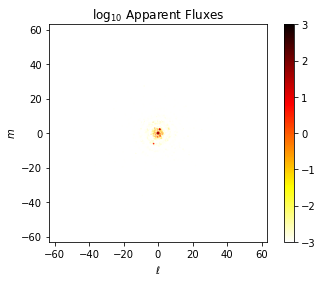

In [18]:

srcListSorted=np.zeros((srcList.shape[0],),dtype=[('ell','float64'),('m','float64'),('s150','float64'),('alpha','float64')])
print srcListSorted.shape
srcListSorted['ell']=srcList[:,0]
srcListSorted['m']=srcList[:,1]
srcListSorted['s150']=beamVals*srcList[:,2]
srcListSorted['alpha']=srcList[:,3]
srcListSorted.sort(order='s150')

fig=plt.figure()
ax=fig.add_subplot(111,axisbg='w')
maxFlux=(srcListSorted['s150']).max()
scp=ax.scatter(180./np.pi*srcListSorted['ell'],
            180./np.pi*srcListSorted['m'],
            s=srcListSorted['s150']/10,
            c=np.log10(srcListSorted['s150']),cmap='hot_r',vmin=-3,vmax=3)
ax.set_aspect('equal')
plt.colorbar(scp)
plt.title('$\\log_{10}$ Apparent Fluxes')
plt.xlabel('$\\ell$')
plt.ylabel('$m$')
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/apparentFluxes_lofar.png',bbox_inches='tight')

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


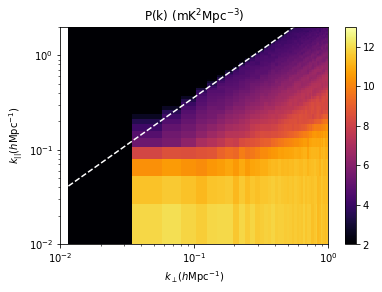

In [19]:
kperp_e,kpara_e,vGrid_true=getCalibrationGrid(testArray,testArrayModel,gains,gains,flagList,nCells=80)
wVal=cosmology.wedge(cosmology.f2z(cFreq))
wLine=kperp_e*wVal
kperpG,kparG=np.meshgrid(kperp_e,kpara_e)
plt.pcolor(kperpG,kparG,np.log10((35e-3)**1.25*vGrid_true),cmap='inferno',vmin=2,vmax=13)
#plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^{-3}$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.show()

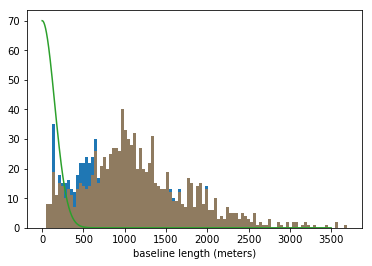

In [20]:
plt.hist(np.abs(np.linalg.norm(testArray.separations,axis=1)),bins=100,alpha=1)
plt.hist(np.abs(np.linalg.norm(testArray.separations[np.invert(flagList)],axis=1)),bins=100,alpha=.5)


x=np.arange(0,3500)
plt.plot(x,70*np.exp(-x**2/(2.*sigma_w**2.)))
plt.xlabel('baseline length (meters)')

In [21]:


def calibrateChannels(data,model,weights,parallel=False):
    output=np.ones((data.shape[0],data.shape[1]),dtype=complex)
    #output=np.array(Parallel(n_jobs=n_cpu/2)(delayed(calibrateChannelParallel)(data[i,:,:],
    #                                                          model[i,:,:],
    #                                                           output[i,:],
    #                                                          weights[i,:,:]) for i in range(data.shape[0])))
    if(parallel):
        output=Parallel(n_jobs=n_cpu/2)(delayed(stefcal.calibrate_2_basic_scaler)(data[i,:,:],
                                                                   model[i,:,:],
                                                                   output[i,:],
                                                                   np.zeros_like(output[i,:]),
                                                                   1e-10,
                                                                   weights[i,:,:],
                                                                   0,
                                                                   5,
                                                                   False) for i in range(data.shape[0]))
    else:
        output=[stefcal.calibrate_2_basic_scaler(data[i,:,:],
                                                 model[i,:,:],
                                                 output[i,:],
                                                 np.zeros_like(output[i,:]),
                                                 1e-10,
                                                 weights[i,:,:],
                                                 0,
                                                 5,
                                                 False) for i in range(data.shape[0])]
    niters=[]
    output_data=[]
    for m in range(len(output)):
        niters.append(output[m][0])
        output_data.append(output[m][1])
    
    return niters,np.array(output_data)
    
    
#def calibrate_2_basic_scaler_cycles_jit(dataMatrix,
#modelMatrix,gains,gbuffer,eps,weights,refant=0,
#n_phase_iter=5,recompute=False,ncycles=1,antFlags=None,visFlags=None):
def calibrateChannelsFlags(data,model,weights,antFlags,flags,eps=1e-10,ncycles=2,parallel=False):
    output=np.ones((data.shape[0],data.shape[1]),dtype=complex)
    #output=np.array(Parallel(n_jobs=n_cpu/2)(delayed(calibrateChannelParallel)(data[i,:,:],
    #                                                          model[i,:,:],
    #                                                           output[i,:],
    #                                                          weights[i,:,:]) for i in range(data.shape[0])))
    if(parallel):
        output=Parallel(n_jobs=n_cpu/2)(delayed(stefcal.calibrate_2_basic_scaler_cycles)(data[i,:,:],
                                                                   model[i,:,:],
                                                                   output[i,:],
                                                                   np.zeros_like(output[i,:]),
                                                                   eps,
                                                                   weights[i,:,:],
                                                                   refant=0,
                                                                   n_phase_iter=5,
                                                                   recompute=False,
                                                                   ncycles=ncycles,
                                                                   antFlags=antFlags,
                                                                   visFlags=flags) for i in range(data.shape[0]))
    else:
        output=[stefcal.calibrate_2_basic_scaler_cycles(data[i,:,:],
                                                       model[i,:,:],
                                                       output[i,:],
                                                       np.zeros_like(output[i,:]),
                                                       eps,
                                                       weights[i,:,:],
                                                       refant=0,
                                                       n_phase_iter=5,
                                                       recompute=False,
                                                       ncycles=ncycles,
                                                       antFlags=antFlags,
                                                       visFlags=flags) for i in range(data.shape[0])]
    niters=[]
    output_data=[]
    for m in range(len(output)):
        niters.append(output[m][0])
        output_data.append(output[m][1])
    
    return niters,np.array(output_data)


In [22]:
print np.sqrt(4000*2*(0.88)**(2.5)*10**0.5*np.pi*(.45*2/4)**2.)
print np.sqrt(4000*2*(0.88)**(2.5)*10**0.5*np.pi*(.45*2/35.)**2.)

54.063702939
6.17870890731


(array([   3.,   24.,   75.,  115.,  118.,  120.,  150.,  234.,  251.,   38.]),
 array([ 1.19316467,  1.25733277,  1.32150087,  1.38566897,  1.44983707,
         1.51400517,  1.57817326,  1.64234136,  1.70650946,  1.77067756,
         1.83484566]),
 <a list of 10 Patch objects>)

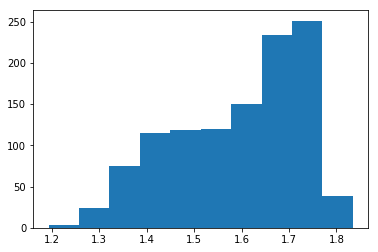

In [23]:
plt.hist(np.log10(np.abs(testArray.visCube[0,:])))

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


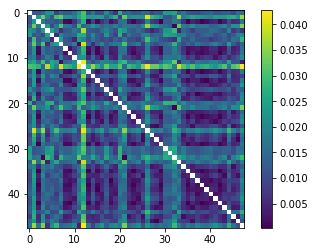

In [24]:

testArray.applyGains(gains)
dCube=testArray.getVisCubeMatrixOrder()
testArray.correctGains(gains)
mCube=testArray.getVisCubeMatrixOrder()
wCube=np.ones_like(mCube)
vF=np.empty((nAnt,nAnt),dtype=bool)
vF[:]=False
nitersPerfect,gainSolutionsPerfect=calibrateChannelsFlags(dCube,mCube,wCube,aFlag,vF,ncycles=5)
plt.imshow(np.abs(1-mCube[0,:,:]/dCube[0,:,:]),interpolation='nearest')
plt.colorbar()

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


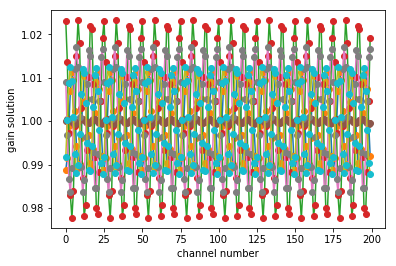

In [25]:
for i in range(5):
    plt.plot(gainSolutionsPerfect[:,i])
    plt.plot(gains[:,i],ls='none',marker='o')

#plt.yscale('log')

plt.ylabel('gain solution')
plt.xlabel('channel number')
plt.legend()
#plt.yscale('log')


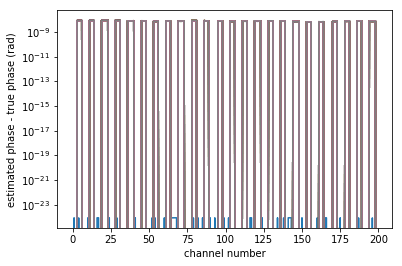

In [26]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutionsPerfect[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.yscale('log')


In [27]:
print np.array(nitersPerfect).astype(int)

[[1129    5    5    5    5]
 [1109    5    5    5    5]
 [ 943    5    5    5    5]
 [1034    5    5    5    5]
 [1079    5    5    5    5]
 [1071    5    5    5    5]
 [ 995    5    5    5    5]
 [1004    5    5    5    5]
 [1114    5    5    5    5]
 [1120    5    5    5    5]
 [1031    5    5    5    5]
 [ 976    5    5    5    5]
 [1069    5    5    5    5]
 [1079    5    5    5    5]
 [1042    5    5    5    5]
 [ 869    5    5    5    5]
 [1106    5    5    5    5]
 [1146    5    5    5    5]
 [1102    5    5    5    5]
 [ 660    5    5    5    5]
 [1074    5    5    5    5]
 [1108    5    5    5    5]
 [1097    5    5    5    5]
 [ 982    5    5    5    5]
 [1083    5    5    5    5]
 [1166    5    5    5    5]
 [1153    5    5    5    5]
 [1031    5    5    5    5]
 [1027    5    5    5    5]
 [1096    5    5    5    5]
 [1096    5    5    5    5]
 [1038    5    5    5    5]
 [ 954    5    5    5    5]
 [1099    5    5    5    5]
 [1108    5    5    5    5]
 [1033    5    5    

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


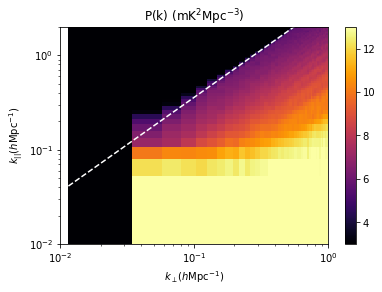

In [28]:
kperp_e,kpara_e,vGrid_true=getCalibrationGrid(testArray,testArrayModel,gains,gainSolutionsPerfect,flagList)
wVal=cosmology.wedge(cosmology.f2z(cFreq))
wLine=kperp_e*wVal
kperpG,kparG=np.meshgrid(kperp_e,kpara_e)
plt.pcolor(kperpG,kparG,np.log10(vGrid_true),cmap='inferno',vmin=3,vmax=13)
#plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^{-3}$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.show()

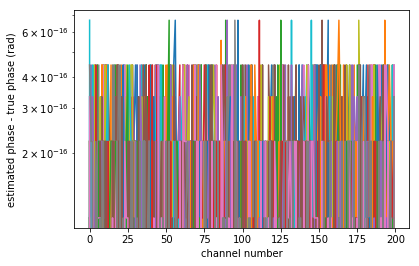

In [29]:
for i in range(gains.shape[1]):
    plt.plot(np.abs(gains[:,i])-np.abs(gainSolutionsPerfect[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.yscale('log')



In [30]:
testArray.applyGains(gains)
dCube=testArray.getVisCubeMatrixOrder()
testArray.correctGains(gains)
mCube=testArrayModel.getVisCubeMatrixOrder()
wCube=np.ones_like(mCube)
vF=np.empty((nAnt,nAnt),dtype=bool)
vF[:]=False
#niters,gainSolutions=calibrateChannelsParallel(dCube,mCube,wCube)
niters,gainSolutions=calibrateChannelsFlags(dCube,mCube,wCube*np.abs(mCube)**2.,aFlag,vF,ncycles=5,parallel=True)

#print niters



In [31]:
print np.array(niters).astype(int)

[[1429  550  468   16    5]
 [1431  430  402   57   12]
 [1407  859  534   36   12]
 [1371  973  534   80   12]
 [1343 1019  377  140   12]
 [1333 1016  516  119   12]
 [1345  959  585  135   12]
 [1367  790  563   89   11]
 [1378  812  255   17    5]
 [1361  864  569   70   11]
 [1305  872  619  149   11]
 [1184  897  596  124   11]
 [1036  927  446   16    5]
 [1176  943  534   23   11]
 [1220  963  592  105   11]
 [1257 1003  531   17    5]
 [1291 1055  547   95   10]
 [1337 1097  684  240   11]
 [1383 1121  732  284   12]
 [1416 1115  732  275   12]
 [1438 1068  665  190   11]
 [1458  913  442   16    5]
 [1479  898  661  172   12]
 [1496  833  661  187   12]
 [1501  990  534   19   11]
 [1493 1089  539  109   12]
 [1477 1091  595  198   13]
 [1454  970  508  139   13]
 [1424 1008  464   17    5]
 [1390 1088  591  145   11]
 [1359 1073  622  185   12]
 [1317  987  621  164   13]
 [1232  581  608   87   12]
 [ 842  875  593   16    5]
 [1120  381  584   16    5]
 [1061  948  586   1

In [32]:
testArray.applyGains(gains)
dCube=testArray.getVisCubeMatrixOrder()
testArray.correctGains(gains)
mCube=testArrayModel.getVisCubeMatrixOrder()
wCube=np.ones_like(mCube)
vF[:]=False
for cnum in range(testArray.nChan):
    wCube[cnum,:,:]=weightsMatrix*np.abs(mCube[cnum,:,:])**2.
nitersWeighted,gainSolutionsWeighted=calibrateChannelsFlags(dCube,mCube,wCube,aFlag,vF,ncycles=10)

In [33]:
print np.array(nitersWeighted).astype(int)



[[ 58108  38993  19712 ...,      5      5      5]
 [ 57033  37293  24982 ...,      5      5      5]
 [ 56671  37588  26982 ...,      5      5      5]
 ..., 
 [156221 113030  69449 ...,      5      5      5]
 [156859 114247  72281 ...,      5      5      5]
 [156818 114931  73972 ...,      5      5      5]]


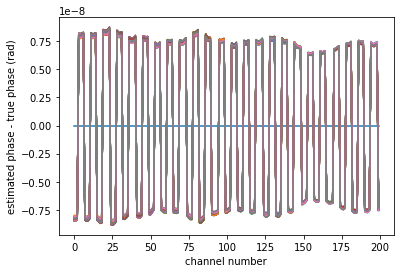

In [34]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutionsPerfect[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()


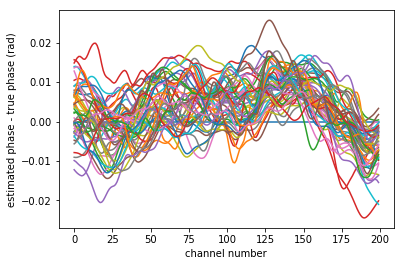

In [53]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutions[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/lofar48_phaseDifference.png',bbox_inches='tight')


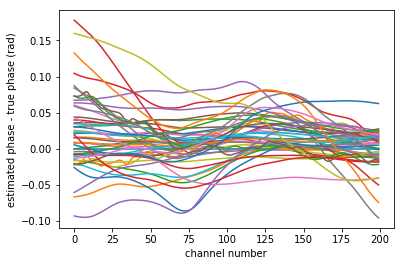

In [52]:
for i in range(gains.shape[1]):
    plt.plot(np.angle(gains[:,i])-np.angle(gainSolutionsWeighted[:,i]))

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/lofar48_phaseDifferenceWeighted.png',bbox_inches='tight')


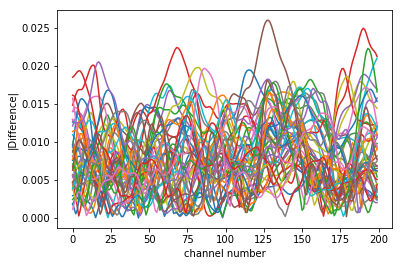

In [37]:
for i in range(gains.shape[1]):
    plt.plot(np.abs(gains[:,i]-gainSolutions[:,i]))

#plt.yscale('log')

plt.ylabel('|Difference|')
plt.xlabel('channel number')
plt.legend()


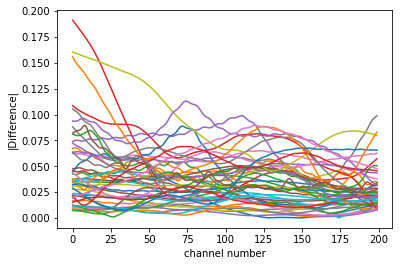

In [38]:
for i in range(gains.shape[1]):
    plt.plot(np.abs(gains[:,i]-gainSolutionsWeighted[:,i]))

#plt.yscale('log')

plt.ylabel('|True Gain-Estimated Gain Weighted|')
plt.xlabel('channel number')
plt.legend()
plt.savefig('writeup/')

In [39]:
print testArray.dAnt

30.0


In [48]:
nC=160
kperp_e,kpara_e,vGrid_true=getCalibrationGrid(testArray,testArrayModel,gains,gains,flagList,nCells=nC)
_,_,vGrid_w=getCalibrationGrid(testArray,testArrayModel,gains,gainSolutionsWeighted,flagList,nCells=nC)
_,_,vGrid_e=getCalibrationGrid(testArray,testArrayModel,gains,gainSolutions,flagList,nCells=nC)


/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


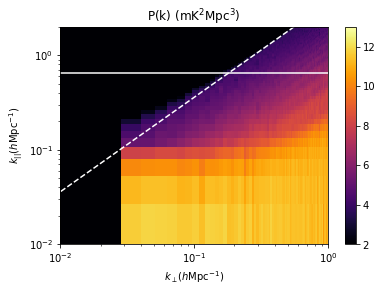

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


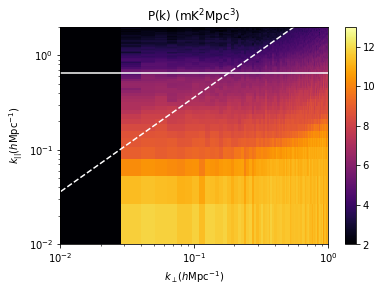

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10


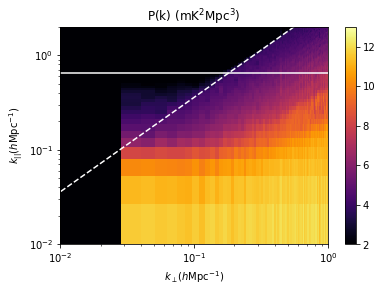

In [49]:
wVal=cosmology.wedge(cosmology.f2z(cFreq))
wLine=kperp_e*wVal
kperpG,kparG=np.meshgrid(kperp_e,kpara_e)

plt.pcolor(kperpG,kparG,np.log10(vGrid_true*(25e-3/1)**1.25),cmap='inferno',vmin=2,vmax=13)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq))/littleh,color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^3$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/lofar48_wedge_noErrors.png',bbox_inches='tight')
plt.show()

plt.pcolor(kperpG,kparG,np.log10(vGrid_e*(25e-3/1)**1.25),cmap='inferno',vmin=2,vmax=13)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq))/littleh,color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^3$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/lofar48_wedge_srcErrors.png',bbox_inches='tight')
plt.show()


plt.pcolor(kperpG,kparG,np.log10(vGrid_w*(25e-3/1)**1.25),cmap='inferno',vmin=2,vmax=13)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq))/littleh,color='w')
plt.plot(kperp_e,wLine,ls='--',color='w')
plt.colorbar()
plt.title('P(k) (mK$^2$Mpc$^3$)')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)
plt.savefig('/csr/mwa/aaronew/stefcal/writeup/lofar48_wedge_weightedErrors.png',bbox_inches='tight')
plt.show()


/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

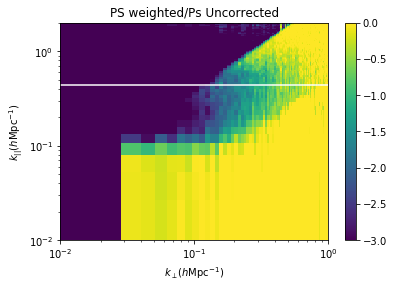

In [50]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_w/vGrid_e),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

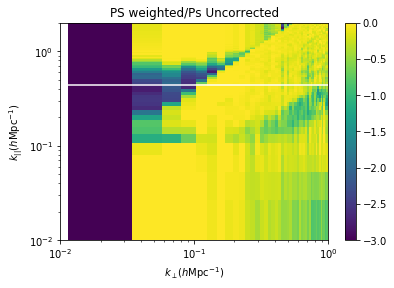

In [43]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_true/vGrid_w),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

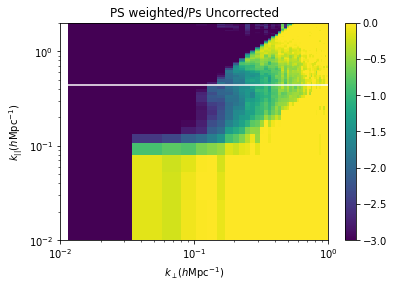

In [44]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_w/vGrid_e),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

/nfs/eor-00/mwa/aaronew/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0.01, 1.0)

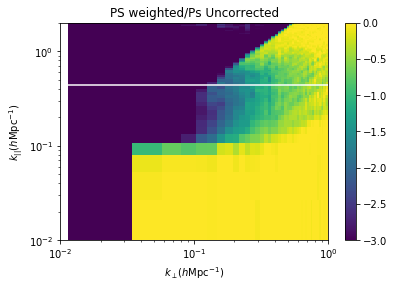

In [45]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_true/vGrid_e),vmin=-3,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2e0)
plt.xlim(1e-2,1e0)

In [46]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_e/vGrid_unCorrect),vmin=-10,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-2,2e0)
plt.xlim(5e-2,1e0)

NameError: name 'vGrid_unCorrect' is not defined

In [ ]:
plt.pcolor(kperpG,kparG,np.log10(vGrid_e/vGrid_w),vmin=-2,vmax=0)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-2,2e0)
plt.xlim(5e-2,1e0)

In [ ]:
plt.pcolor(kperpG,kparG,(vGrid_w/vGrid_e),vmin=1,vmax=10)
plt.axhline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='w')
plt.colorbar()
plt.title('PS weighted/Ps Uncorrected')
plt.xlabel('$k_\perp$($h$Mpc$^{-1}$)')
plt.ylabel('$k_{||}$($h$Mpc$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-2,2e0)
plt.xlim(5e-2,1e0)

In [ ]:
275/sum(np.abs(weightsMatrix.flatten())/np.abs(weightsMatrix.flatten()).max())

In [ ]:
nf=testArray.nChan
window=signal.blackmanharris(nf)
window/=np.sqrt(np.mean(window**2.))
for i in range(gains.shape[1]):
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]-gainSolutions[:,i])))[:nf/2])
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]-gainSolutionsWeighted[:,i])))[:nf/2],ls='--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-2,1e0)
plt.ylim(1e-8,1e1)
#plt.ylim(1e-1,1e1)
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')

In [ ]:
for i in range(8,9):
    plt.plot(np.abs(gains[:,i]/gainSolutions[:,i])**-1,ls='-')
    plt.plot(np.abs(gains[:,i]/gainSolutionsWeighted[:,i])**-1,ls='-')
    plt.plot(np.abs(gains[:,i]),lw=2,color='k')

#plt.yscale('log')

plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('channel number')
plt.legend()
plt.show()






In [ ]:
for i in range(1):
    plt.plot(kpara_e,np.abs((fft.ifft(window*(gains[:,i]/gainSolutions[:,i])**-1)))[:nf/2],ls='--')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('kpara')
plt.legend()
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')




In [ ]:
for i in range(1):
    plt.plot(kpara_e,np.abs((fft.ifft(window*(gains[:,i]/gainSolutionsWeighted[:,i])**-1)))[:nf/2],ls='--')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('estimated phase - true phase (rad)')
plt.xlabel('kpara')
plt.legend()
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')





In [ ]:
nf=testArray.nChan
window=signal.blackmanharris(nf)
window/=np.sqrt(np.mean(window**2.))
for i in range(gains.shape[1]):
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]/gainSolutions[:,i])))[:nf/2])
    plt.plot(kpara_e,np.abs(fft.fft(window*(gains[:,i]/gainSolutionsWeighted[:,i])))[:nf/2],ls='--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-2,1e0)
plt.ylim(1e-5,1e-3)
#plt.ylim(1e-1,1e1)
plt.axvline(cosmology.eta2kpara(rDelay,cosmology.f2z(cFreq)),color='k',ls='--')